In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import os

# --- SETUP ---
PLOT_DIR = "analysis/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="white")

# --- DATEN (Ohne "Grid Conv") ---
data = {
    "Experiment": [
        "Baseline", 
        "Bugfix", 
        "Grid (Spk)",      # Grid (Conv) ist raus
        "Optuna",          # Das ist unser Highlight
        "Optuna CV (2E)",  # Vergleich 1
        "Optuna (5E)"      # Vergleich 2
    ],
    # Speaker F1 (Balken)
    "Spk_Train":  [0.784, 0.799, 0.846, 0.885, 0.885, 0.822],
    "Spk_Dev":    [0.789, 0.837, 0.881, 0.906, 0.877, 0.884],
    
    # Conversational F1 (Linien)
    "Conv_Train": [0.859, 0.870, 0.896, 0.925, 0.935, 0.888],
    "Conv_Dev":   [0.815, 0.855, 0.877, 0.903, 0.880, 0.889]
}
df = pd.DataFrame(data)

# Index von "Optuna" finden (für das permanente Highlight)
IDX_OPTUNA = 3 

# --- FARBEN ---
# DEV (Orange, Wichtig, Solid)
COL_DEV_BAR    = "#ff9e4a" 
COL_DEV_LINE   = "#d65f00"

# TRAIN (Blau, Sekundär, Schraffiert)
COL_TRAIN_BAR  = "#a6cee3"
COL_TRAIN_LINE = "#1f78b4"

In [18]:
def plot_bar_phase(step_index, step_name_for_file):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(df))
    width = 0.38 # Etwas breiter
    
    # --- BALKEN ZEICHNEN ---
    for i in range(len(df)):
        if i > step_index: continue
        
        # LOGIK: Wer ist "aktiv" (kräftig)?
        # 1. Der aktuelle Schritt
        # 2. ODER "Optuna" (IDX_OPTUNA), wenn wir schon weiter sind (als Referenz)
        is_highlight = (i == step_index) or (i == IDX_OPTUNA and step_index > IDX_OPTUNA)
        
        alpha = 1.0 if is_highlight else 0.3
        # Wenn nicht highlight, machen wir die Schrift dünn/grau
        text_color = 'black' if is_highlight else 'gray'
        weight = 'bold' if is_highlight else 'normal'
        
        # --- 1. DEV BALKEN (ORANGE - LINKS - WICHTIG) ---
        # Keine Schraffur, volle Farbe
        bar_dev = ax.bar(x[i] - width/2, df["Spk_Dev"][i], width, 
                         color=COL_DEV_BAR, alpha=alpha, label='_nolegend_')
        
        # --- 2. TRAIN BALKEN (BLAU - RECHTS - SEKUNDÄR) ---
        # Mit Schraffur (///)
        bar_train = ax.bar(x[i] + width/2, df["Spk_Train"][i], width, 
                           color=COL_TRAIN_BAR, alpha=alpha, 
                           hatch='///', edgecolor='white' if not is_highlight else COL_TRAIN_LINE, # Randfarbe für Schraffur
                           label='_nolegend_')
        
        # --- WERTE (GROSS DARSTELLEN) ---
        # Dev Werte
        ax.bar_label(bar_dev, padding=3, fmt='%.3f', fontsize=12, 
                     color=text_color, weight=weight)
        
        # Train Werte
        ax.bar_label(bar_train, padding=3, fmt='%.3f', fontsize=12, 
                     color=text_color, weight=weight)

    # --- TRENNLINIE (Vertikal) ---
    # Zeichnen wir nur, wenn wir schon bei den Vergleichs-Schritten sind
    if step_index > IDX_OPTUNA:
        # Linie zwischen Optuna und dem nächsten
        separator_x = IDX_OPTUNA + 0.5 
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
        
        # Optional: Text an der Linie
        ax.text(separator_x, 1.05, "Vergleich Epochen", ha='center', va='bottom', 
                color='gray', fontsize=10, style='italic', backgroundcolor='white')

    # --- LAYOUT ---
    ax.set_ylabel('Speaker F1-Score', fontsize=13)
    ax.set_title(f'Optimierung Speaker F1: {df["Experiment"][step_index]}', fontsize=16, pad=20)
    
    # X-Achse
    ax.set_xlim(-0.6, len(df) - 0.4)
    ax.set_xticks(x[:step_index+1])
    ax.set_xticklabels(df["Experiment"][:step_index+1], rotation=15, ha='right', fontsize=12)
    
    # Y-Achse
    ax.set_ylim(0.0, 1.12)
    ax.grid(True, axis='y', linestyle=':', alpha=0.4)
    
    # --- CUSTOM LEGENDE ---
    # Dev = Solid Orange Box
    h_dev = mpatches.Patch(color=COL_DEV_BAR, label='Dev (Validierung)')
    # Train = Schraffierte Blaue Box
    h_train = mpatches.Patch(facecolor=COL_TRAIN_BAR, hatch='///', edgecolor=COL_TRAIN_LINE, label='Train (Referenz)')
    
    ax.legend(handles=[h_dev, h_train], loc='lower right', fontsize=12, frameon=True, shadow=True)
    
    plt.tight_layout()
    filename = f"phase1_step_{step_index:02d}_{step_name_for_file}.png"
    plt.savefig(os.path.join(PLOT_DIR, filename), dpi=300)
    plt.show()

In [19]:
def plot_lines_final():
    
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df))
    width = 0.38
    
    # --- 1. BALKEN (HINTERGRUND) ---
    for i in range(len(df)):
        # Dev (Orange)
        ax.bar(x[i] - width/2, df["Spk_Dev"][i], width, color=COL_DEV_BAR, alpha=0.25) # Ganz blass
        # Train (Blau Schraffiert)
        ax.bar(x[i] + width/2, df["Spk_Train"][i], width, color=COL_TRAIN_BAR, alpha=0.25, hatch='///', edgecolor='white')
        
        # KEINE LABELS HIER!
        
    # Trennlinie auch hier
    ax.axvline(x=IDX_OPTUNA + 0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)

    # --- 2. LINIEN (VORDERGRUND) ---
    # Dev Linie (Solid, Wichtig)
    ax.plot(x, df["Conv_Dev"], color=COL_DEV_LINE, marker='D', markersize=9, linewidth=3, label='Conv F1 (Dev)')
    
    # Train Linie (Dashed, Sekundär)
    ax.plot(x, df["Conv_Train"], color=COL_TRAIN_LINE, marker='o', markersize=7, linewidth=2, linestyle='--', label='Conv F1 (Train)')
    
    # --- 3. LABELS NUR AN DEN LINIEN ---
    for i in range(len(df)):
        
        # Dev Wert (Oben)
        val_dev = df["Conv_Dev"][i]
        ax.annotate(f'{val_dev:.3f}', xy=(x[i], val_dev), xytext=(0, 12), 
                    textcoords='offset points', ha='center', 
                    fontsize=11, weight='bold', color=COL_DEV_LINE,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
        
        # Train Wert (Unten)
        val_train = df["Conv_Train"][i]
        # Kleiner Trick: Wenn Train sehr nah an Dev ist, schieben wir Train nach unten, sonst nach oben
        offset = -18 if val_train < val_dev else 18
        
        ax.annotate(f'{val_train:.3f}', xy=(x[i], val_train), xytext=(0, offset), 
                    textcoords='offset points', ha='center', 
                    fontsize=10, weight='normal', color=COL_TRAIN_LINE,
                    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none", alpha=0.6))

    # --- LAYOUT ---
    ax.set_ylabel('F1-Score', fontsize=13)
    ax.set_title('Vergleich mit Conversational F1-Score (Linien)', fontsize=16, pad=20)
    
    ax.set_xticks(x)
    ax.set_xticklabels(df["Experiment"], rotation=15, ha='right', fontsize=12)
    ax.set_ylim(0.0, 1.12)
    
    # Legende (Jetzt Linien Fokus)
    h_line_dev = mlines.Line2D([], [], color=COL_DEV_LINE, marker='D', linewidth=3, label='Conv F1 (Dev)')
    h_line_tr  = mlines.Line2D([], [], color=COL_TRAIN_LINE, marker='o', linestyle='--', linewidth=2, label='Conv F1 (Train)')
    
    ax.legend(handles=[h_line_dev, h_line_tr], loc='lower right', fontsize=12, frameon=True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "phase2_lines_final.png"), dpi=300)
    plt.show()

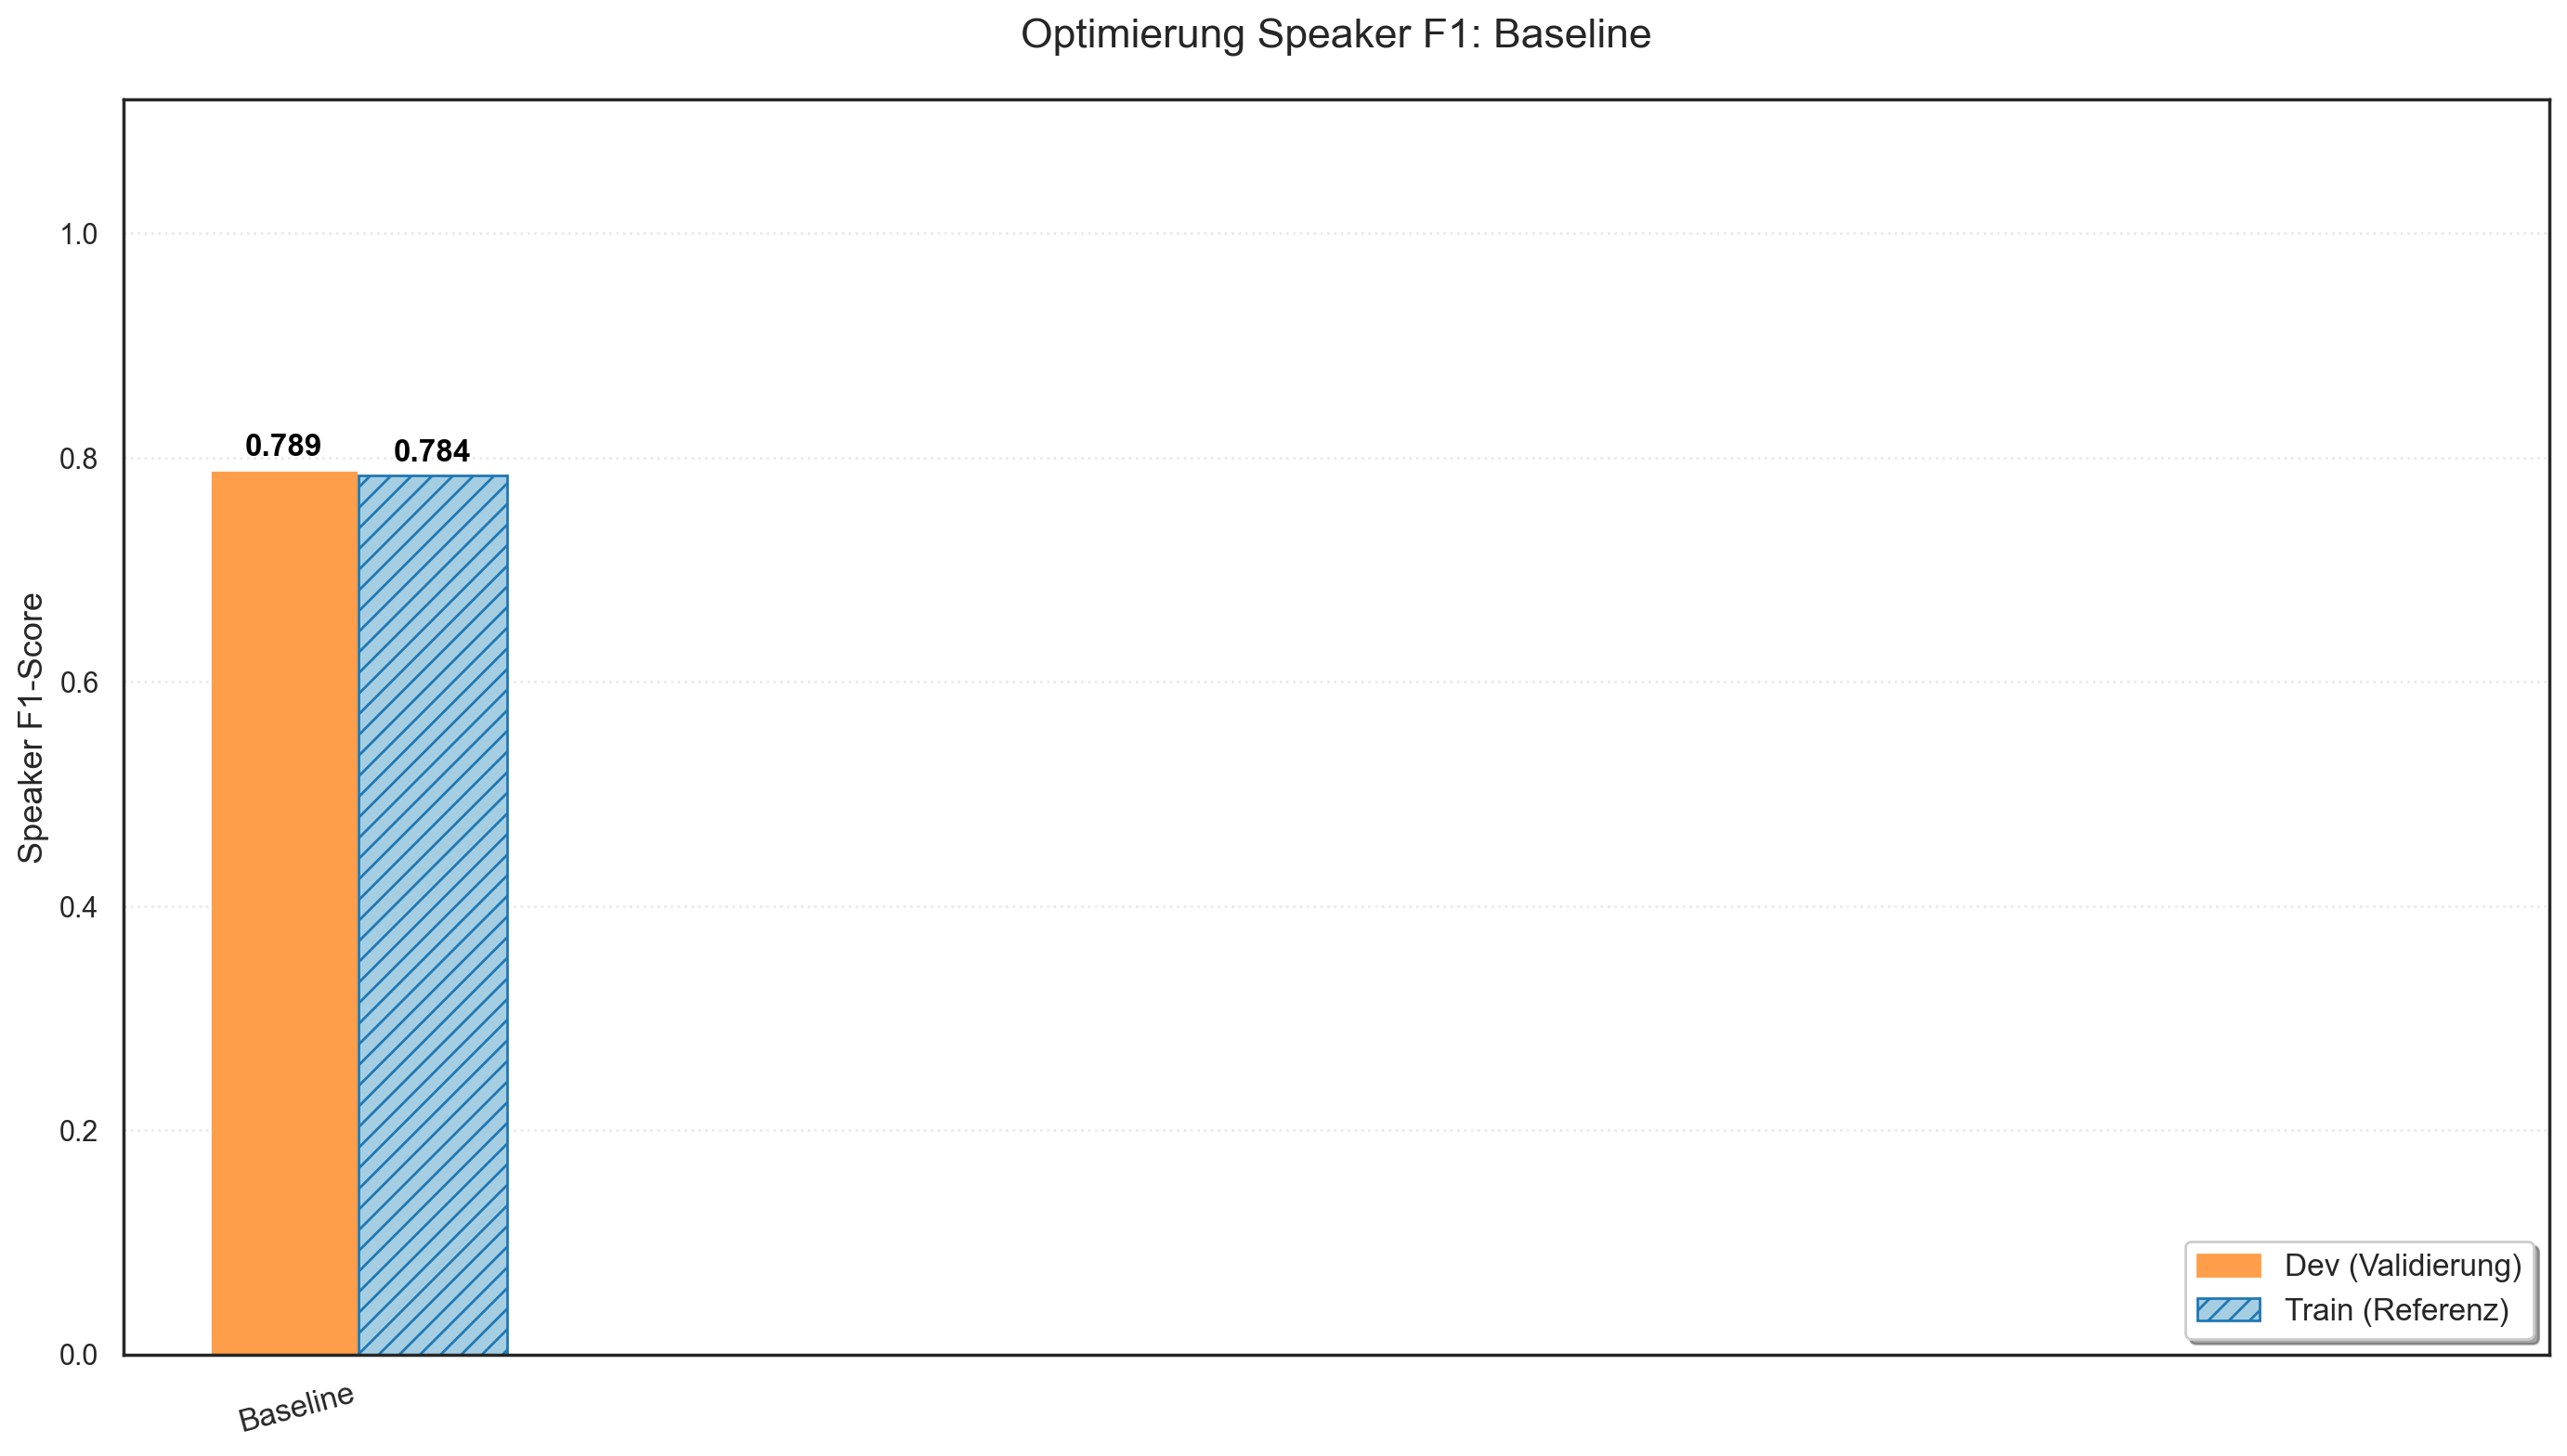

In [20]:
plot_bar_phase(0, "baseline")

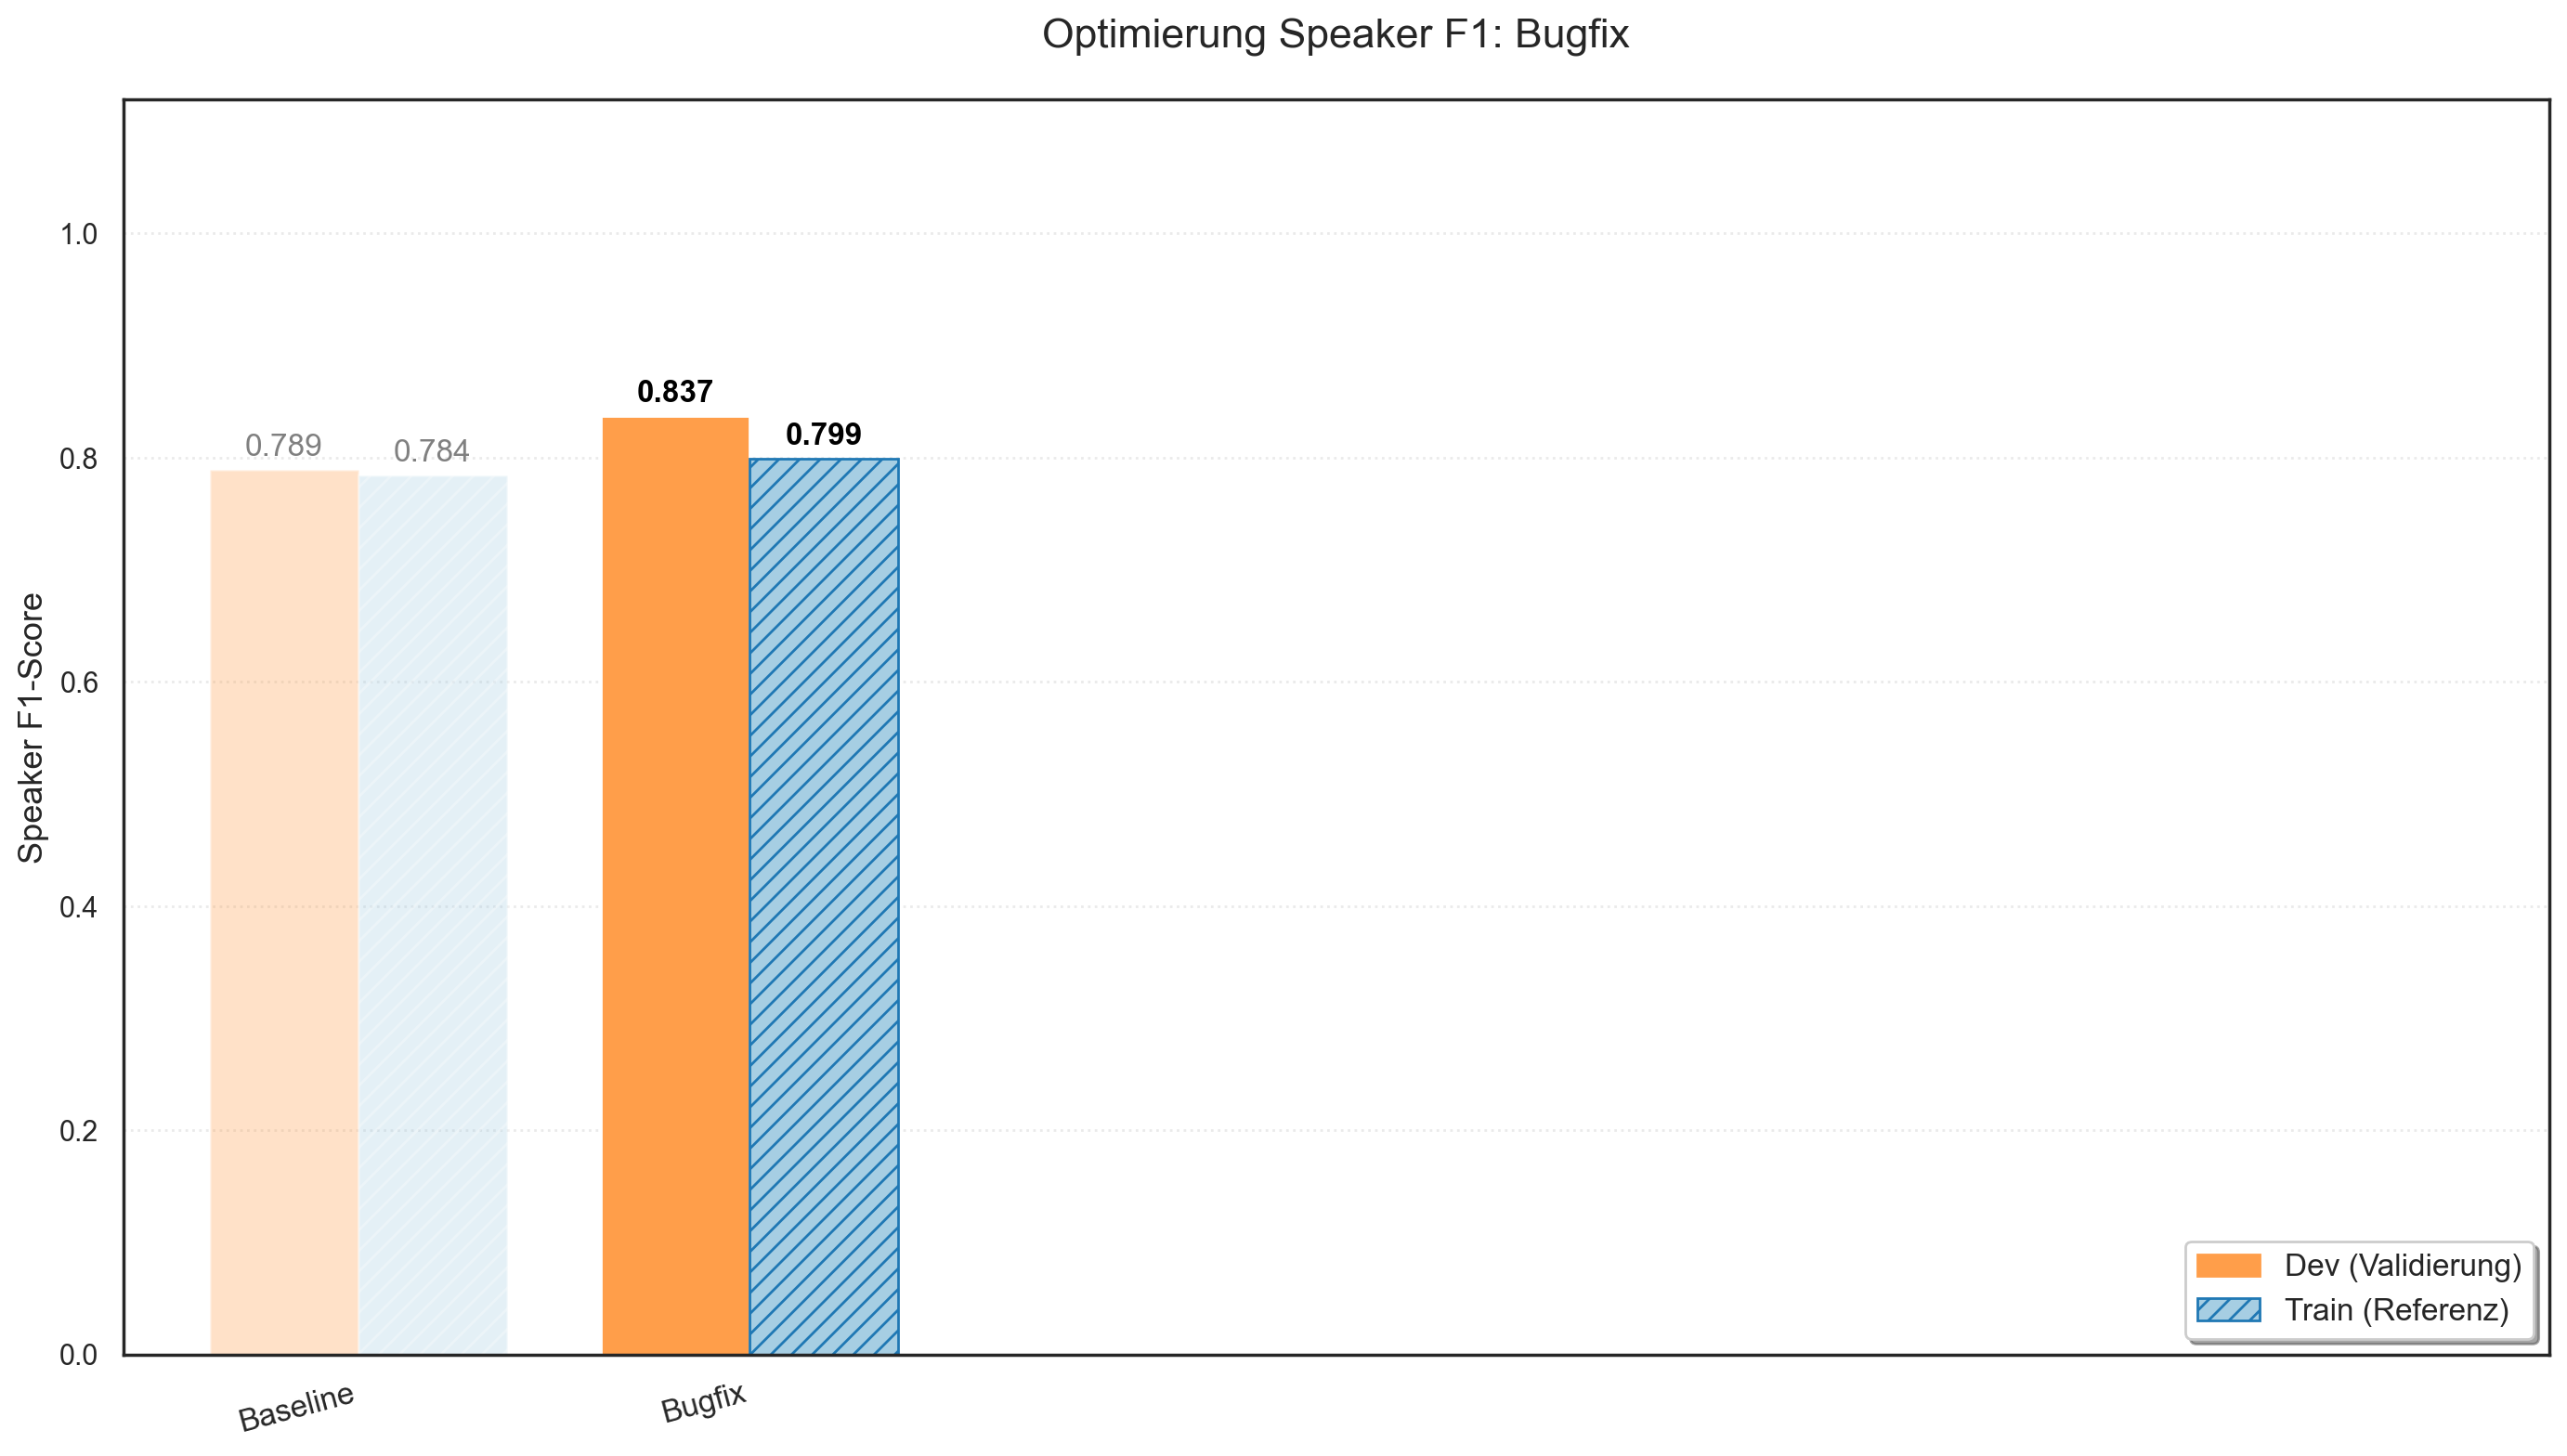

In [21]:
plot_bar_phase(1, "bugfix")

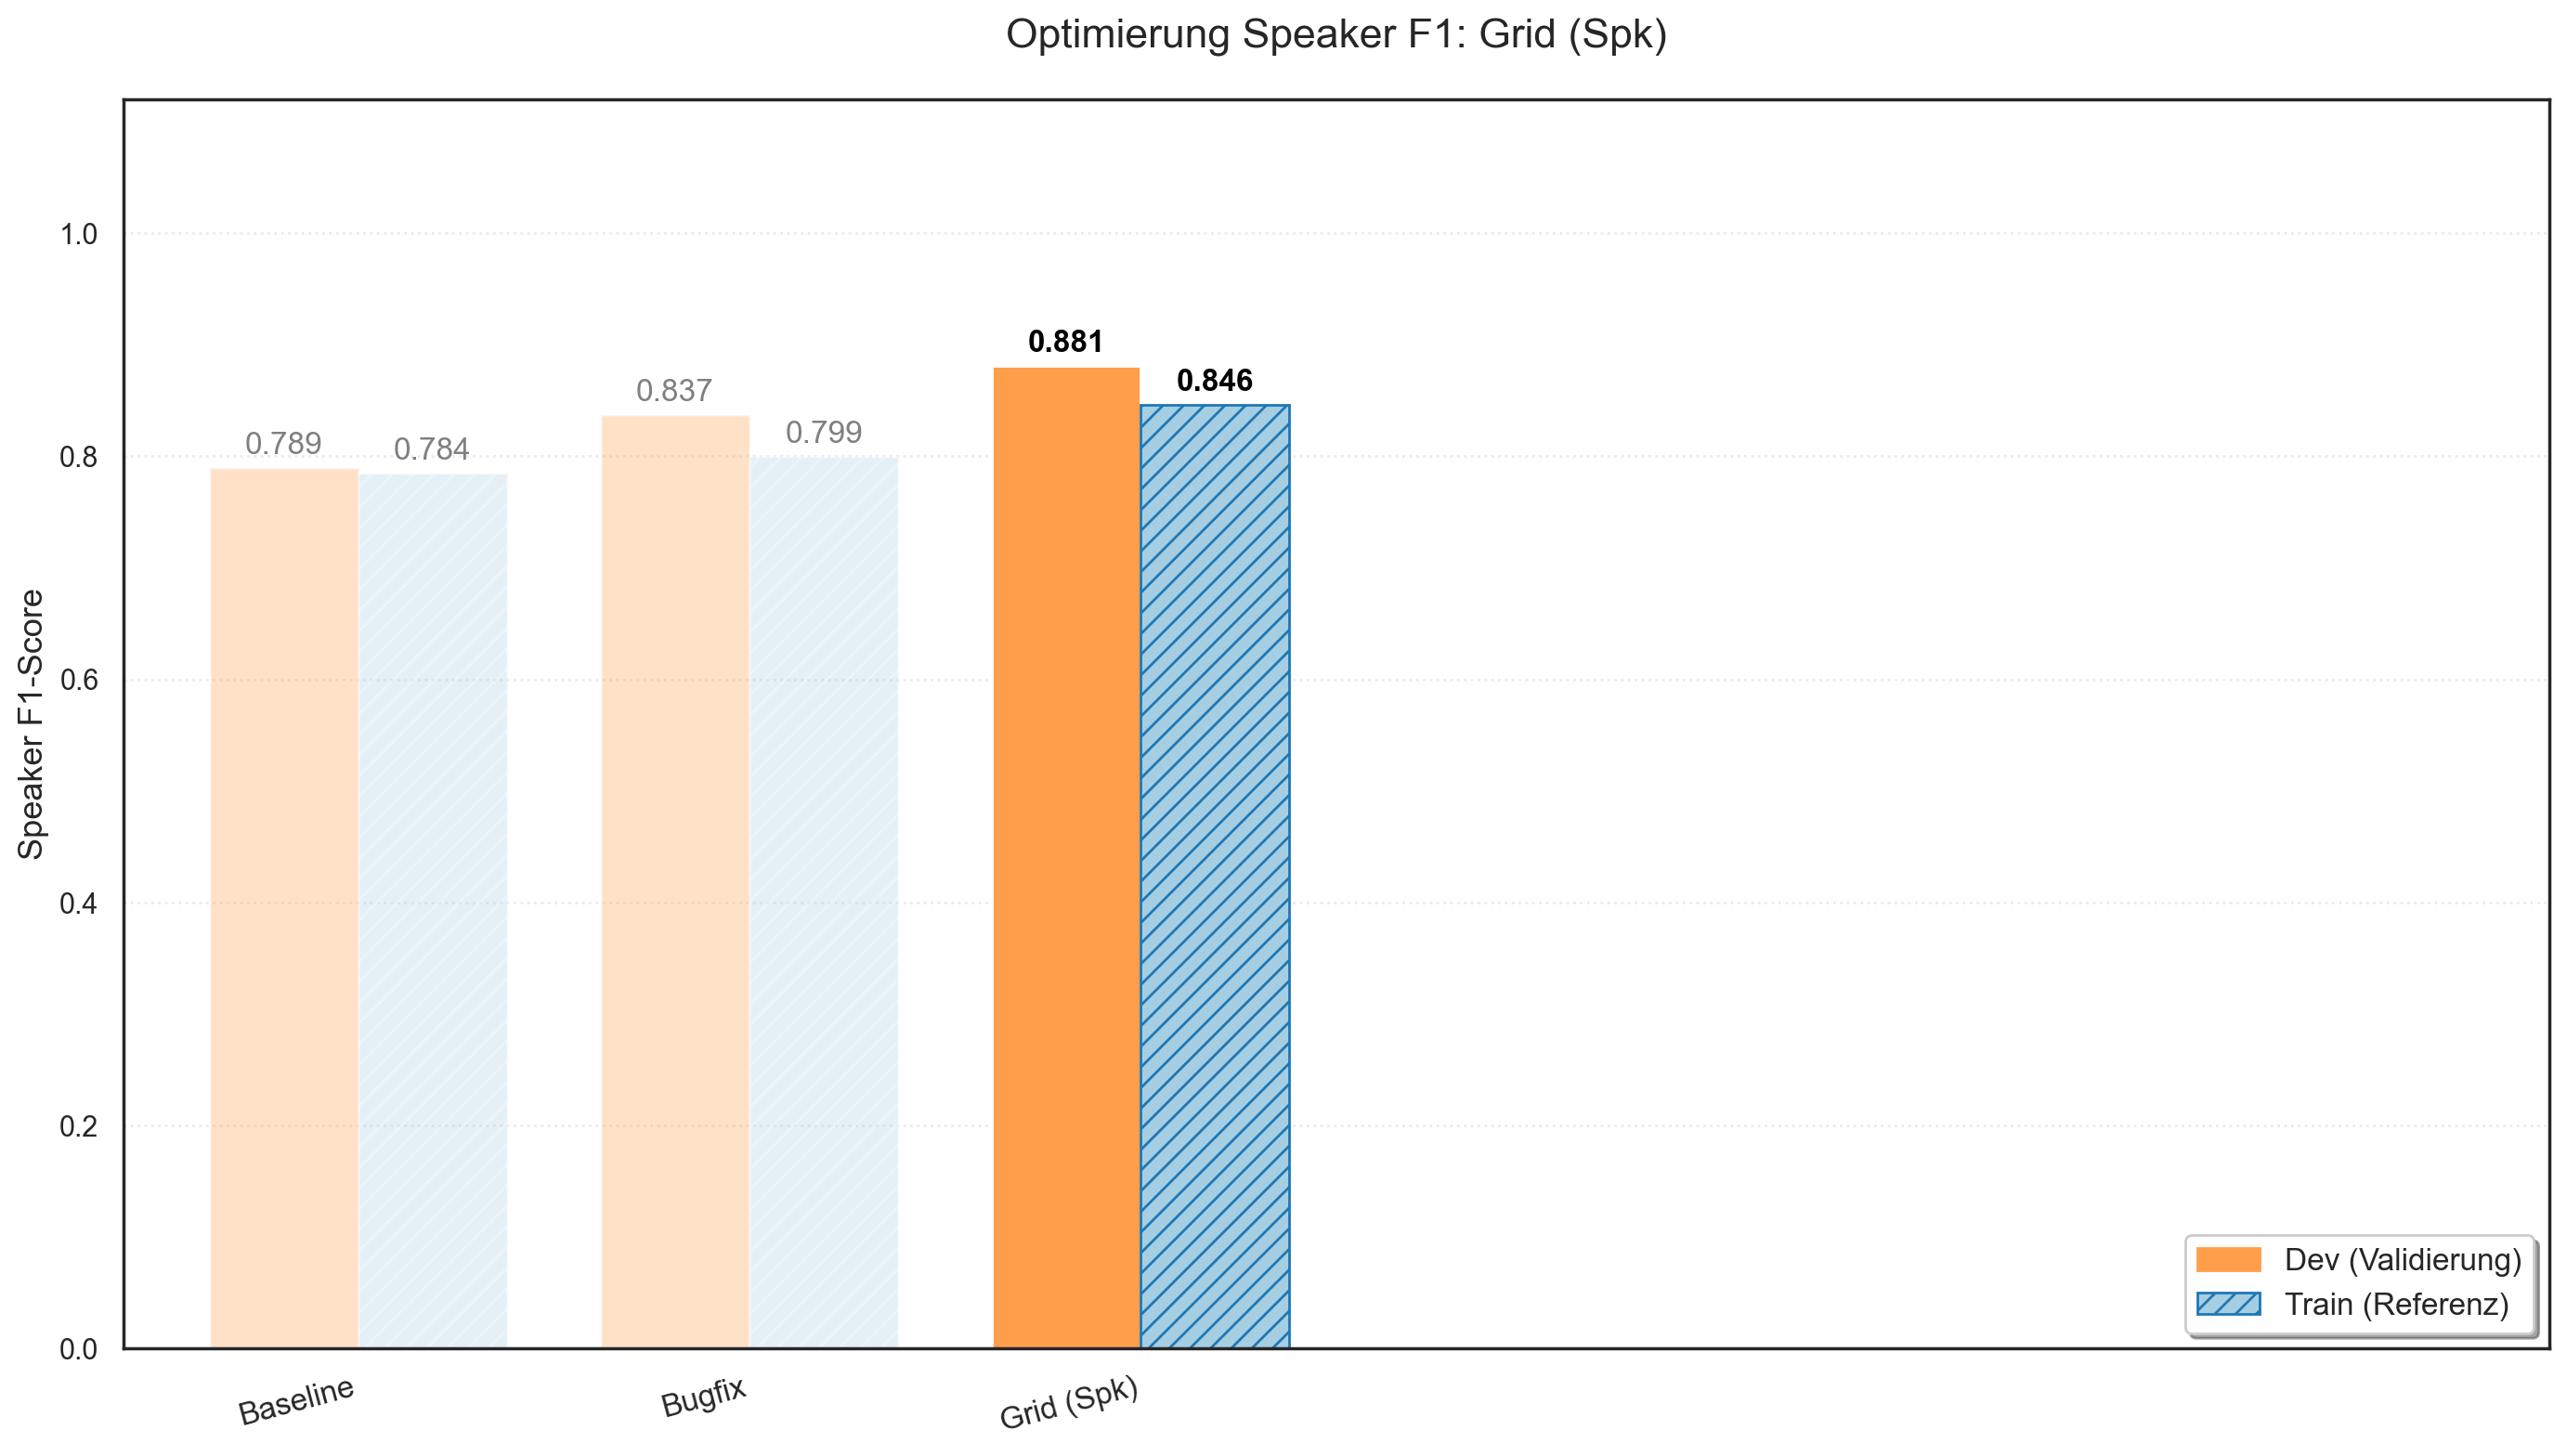

In [22]:
plot_bar_phase(2, "grid_speaker")

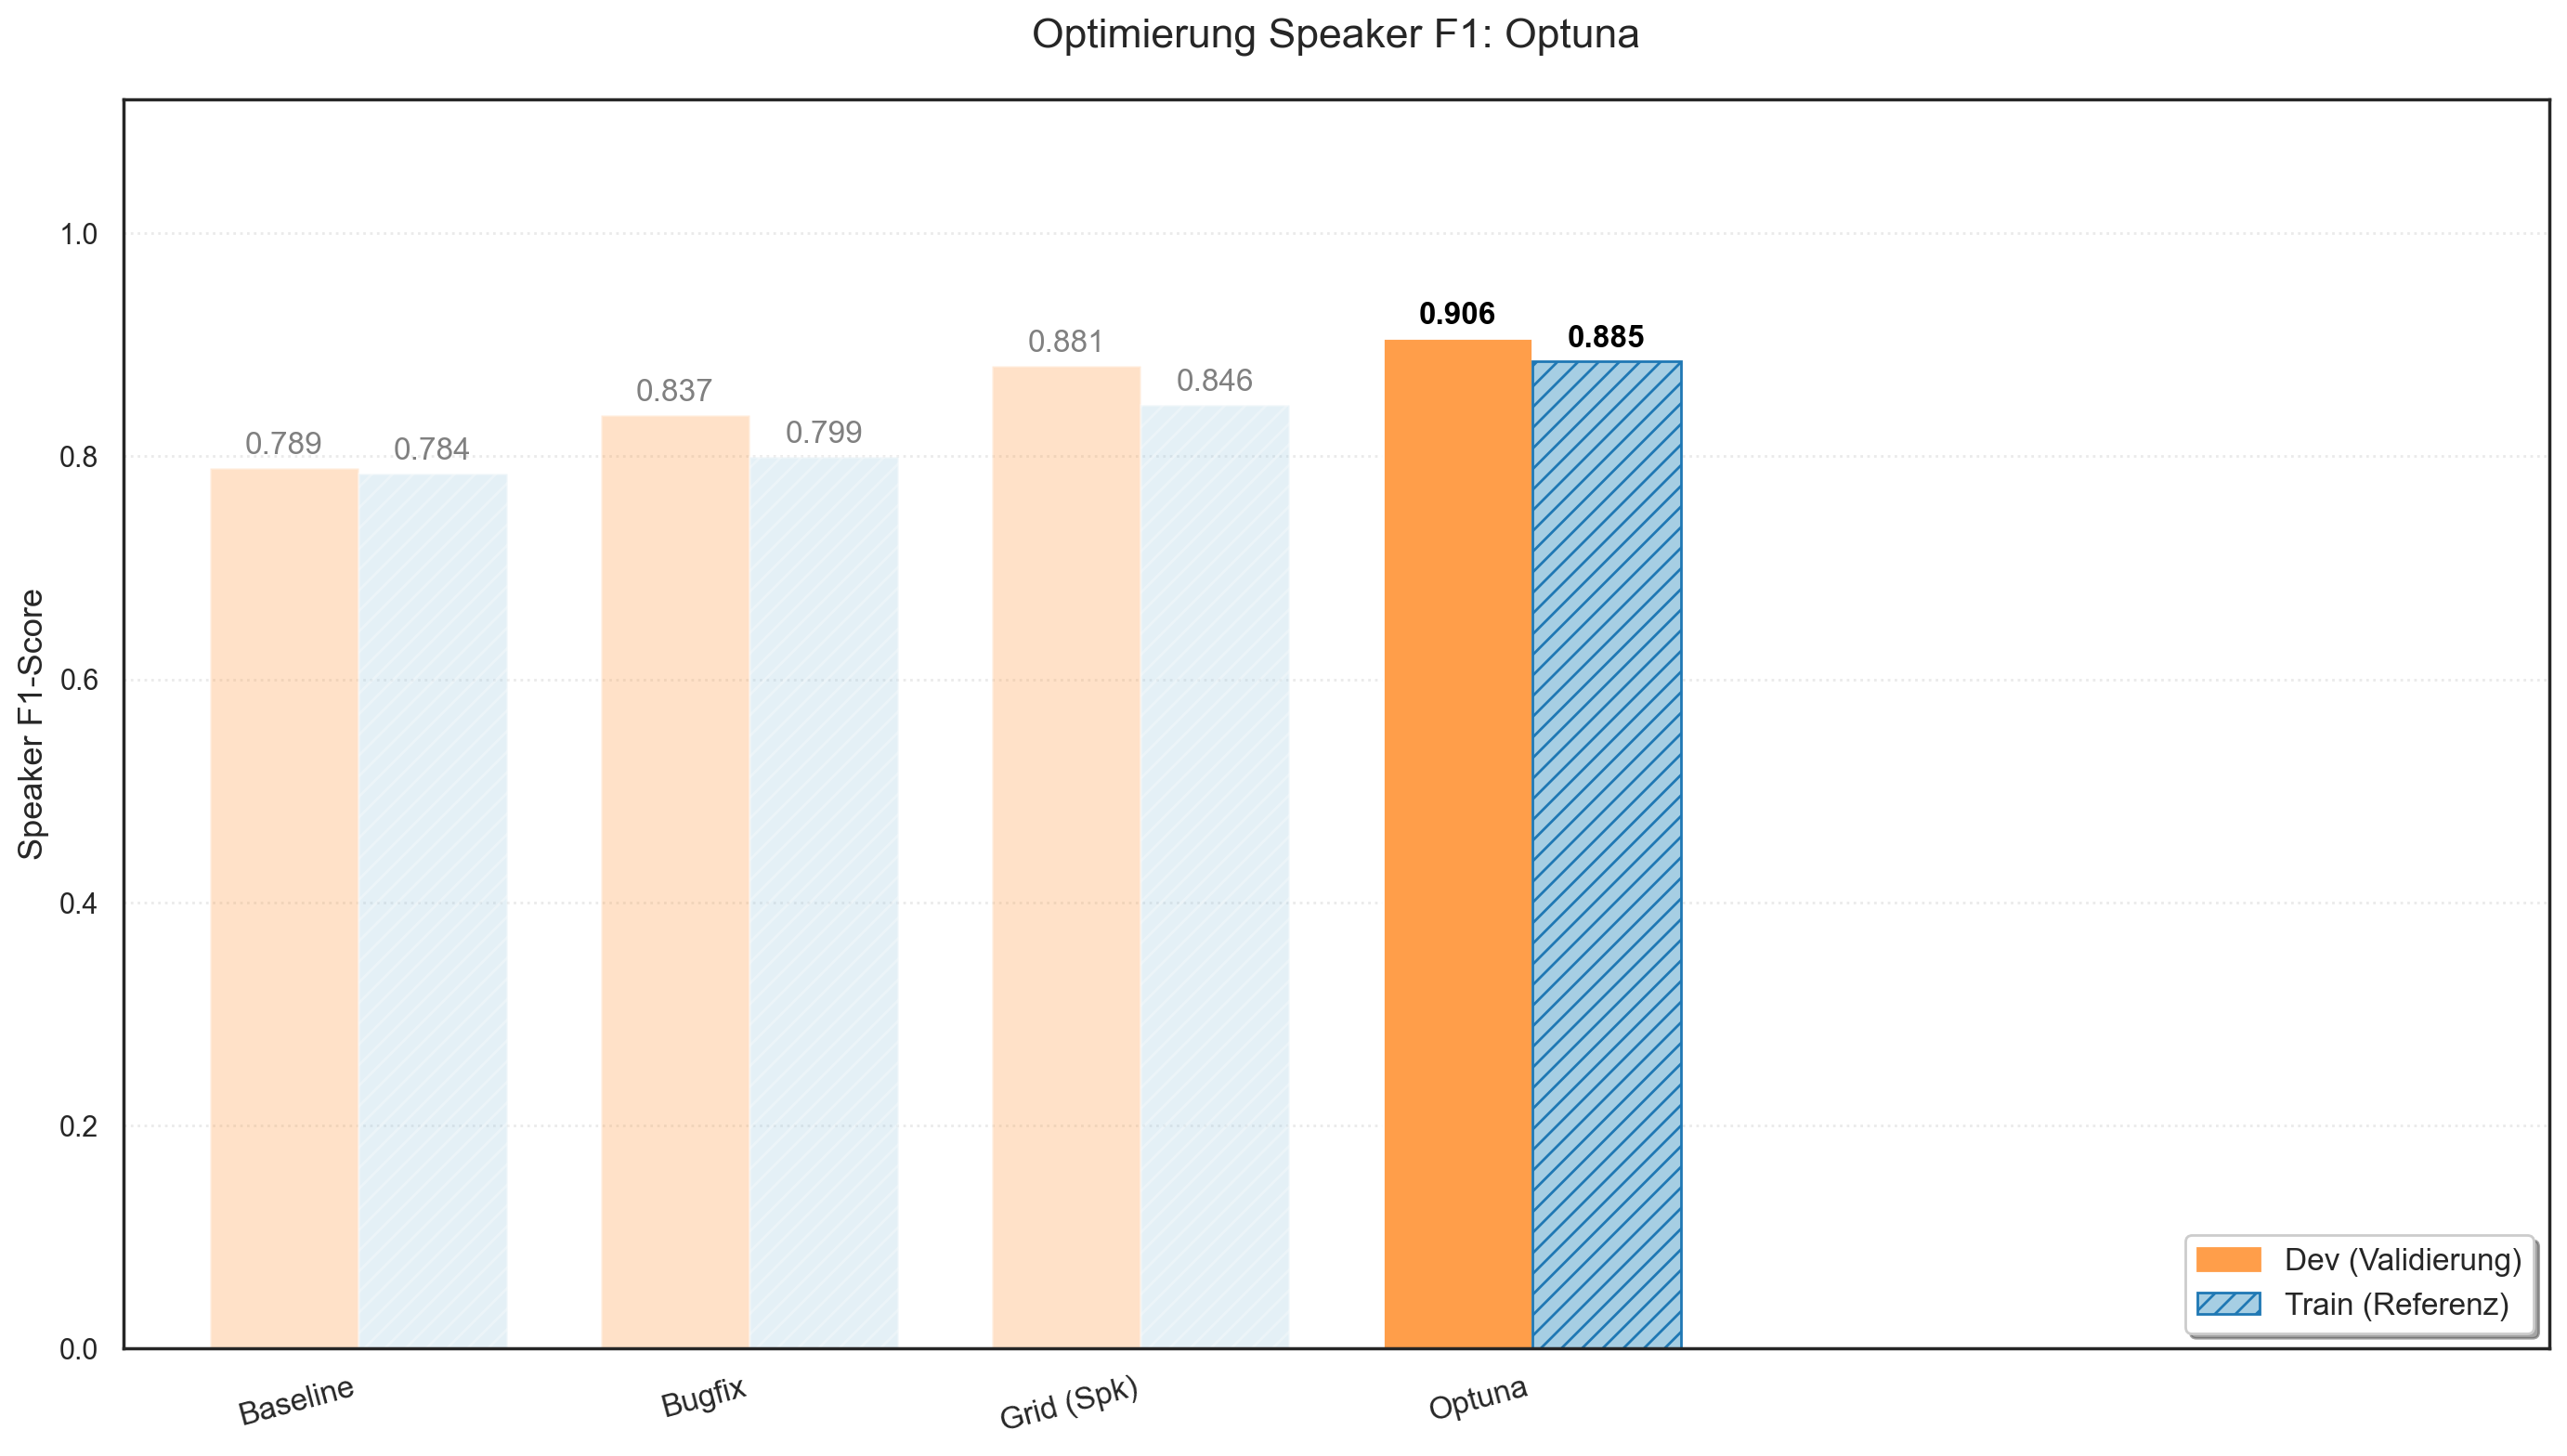

In [23]:
plot_bar_phase(3, "optuna")

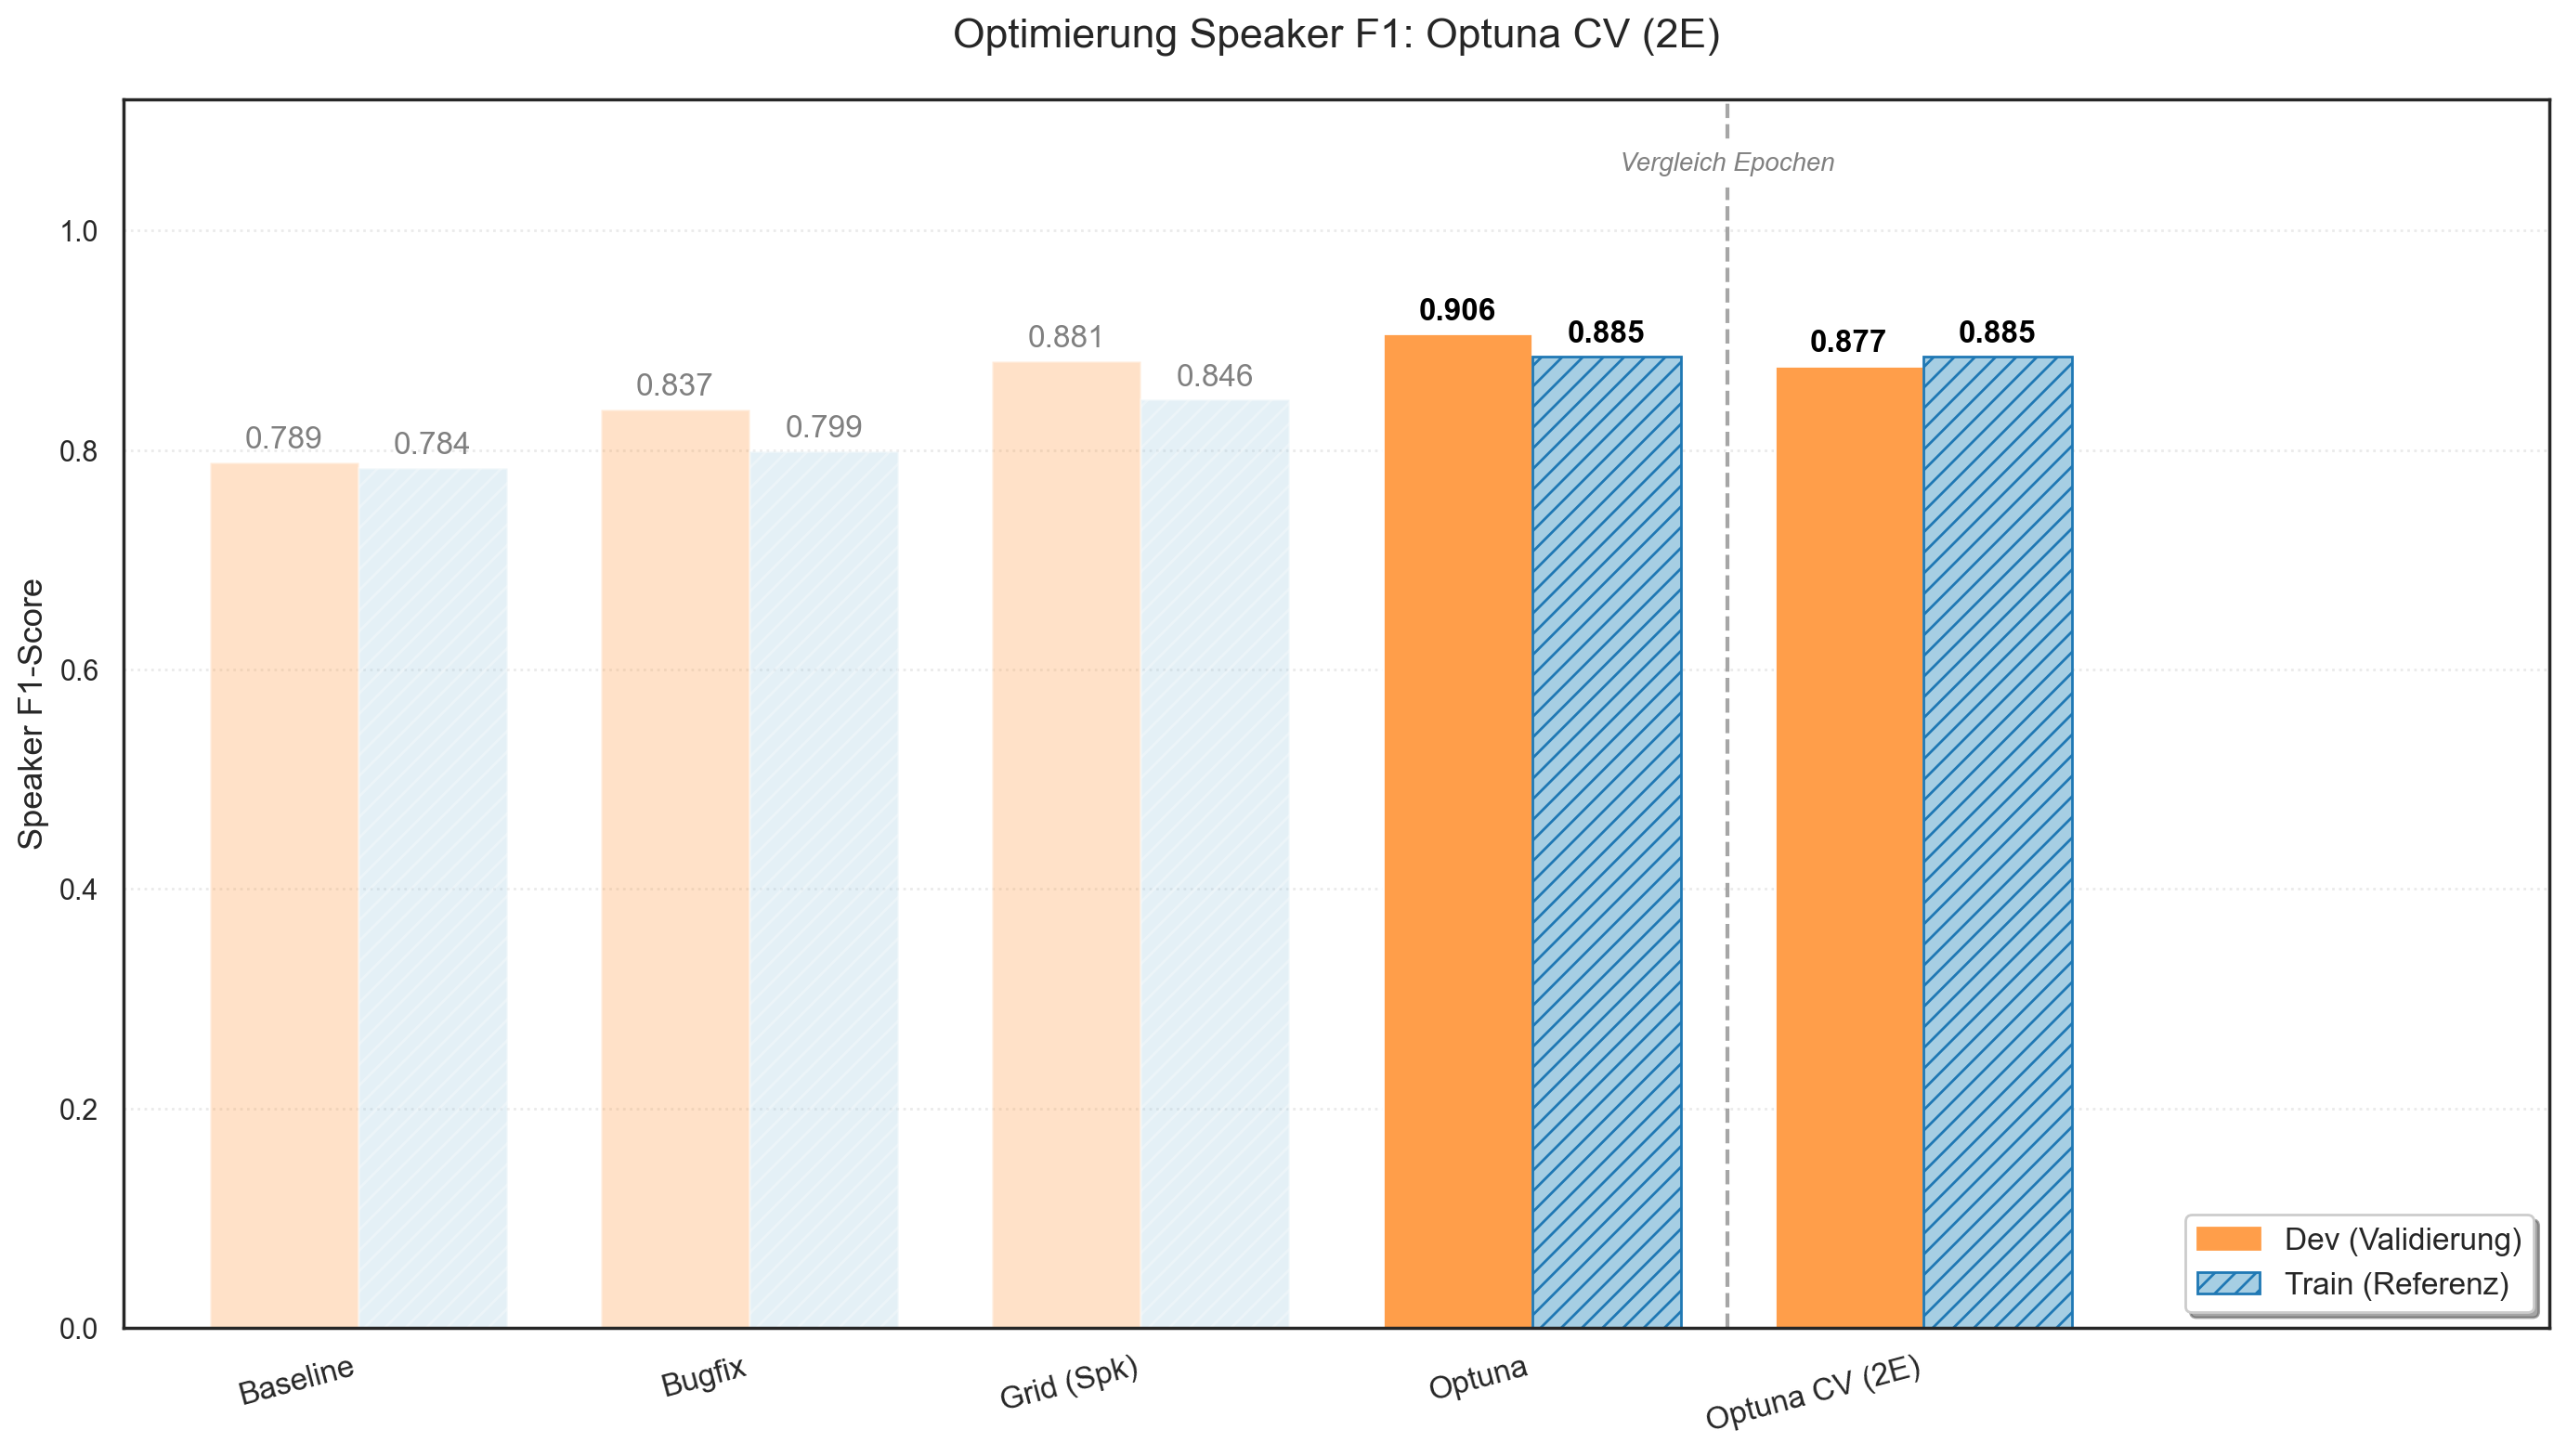

In [24]:
plot_bar_phase(4, "optuna_cv_2e")

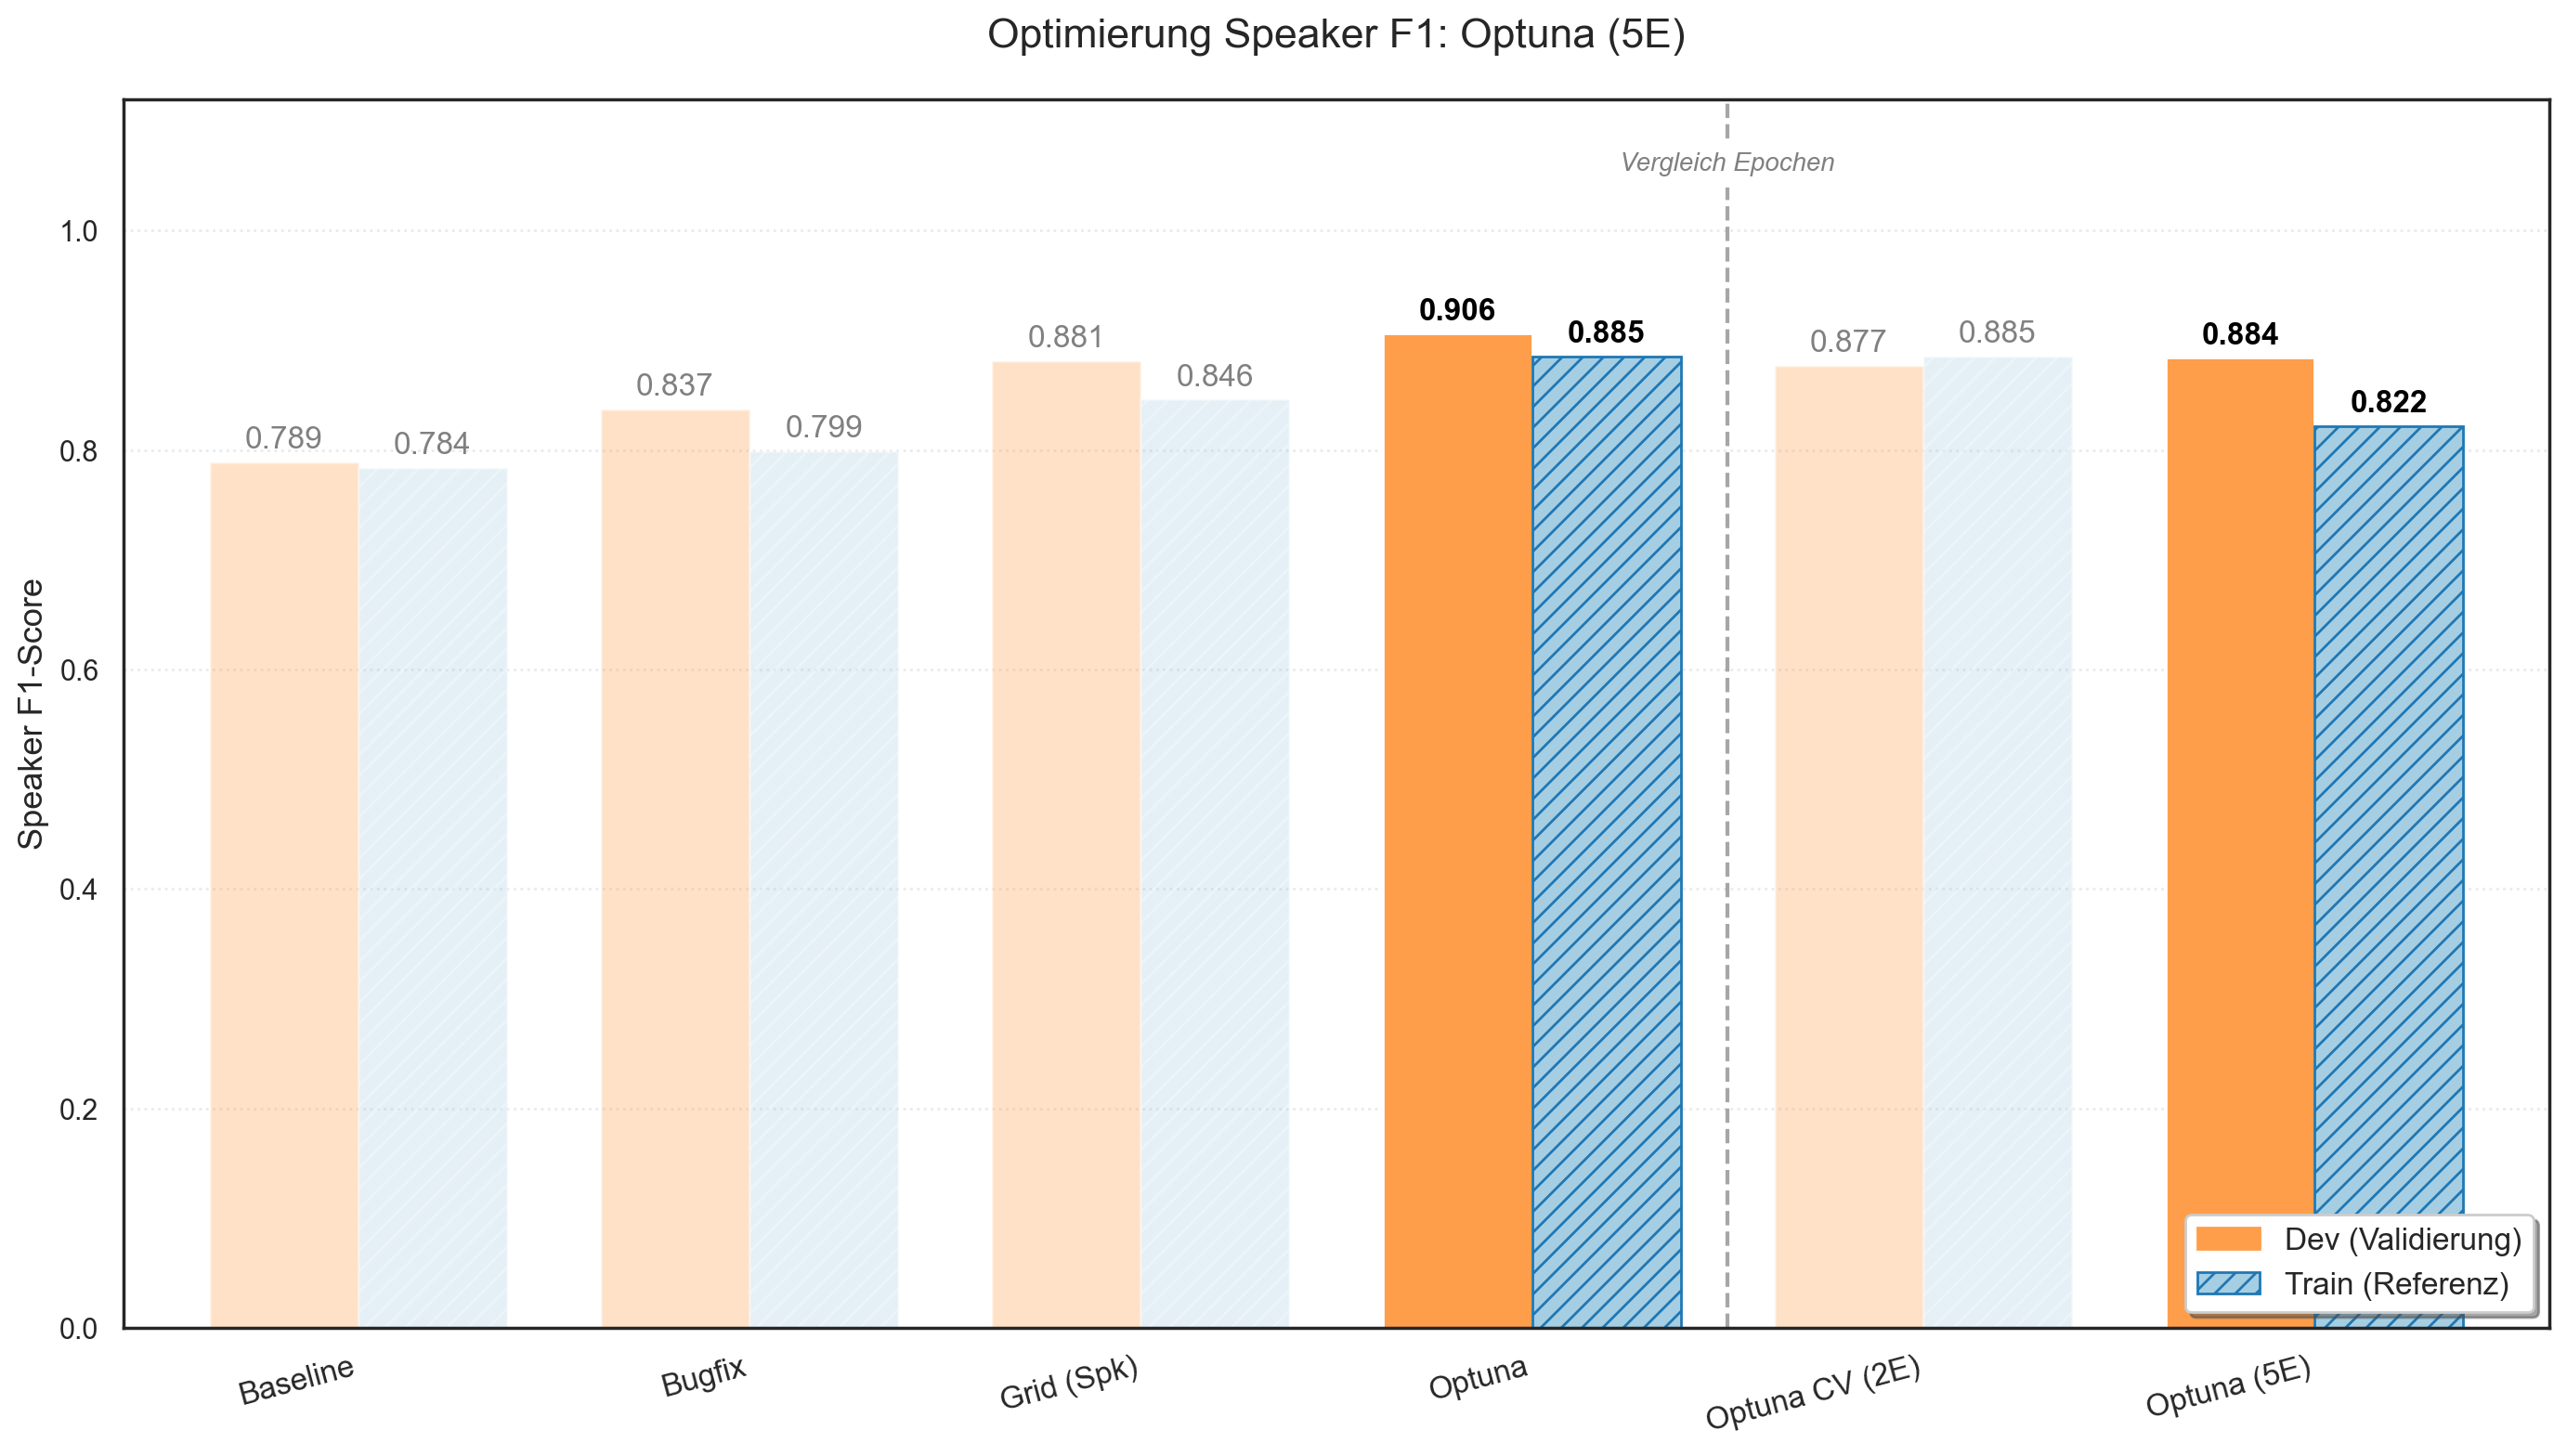

In [26]:
plot_bar_phase(5, "optuna_5e")

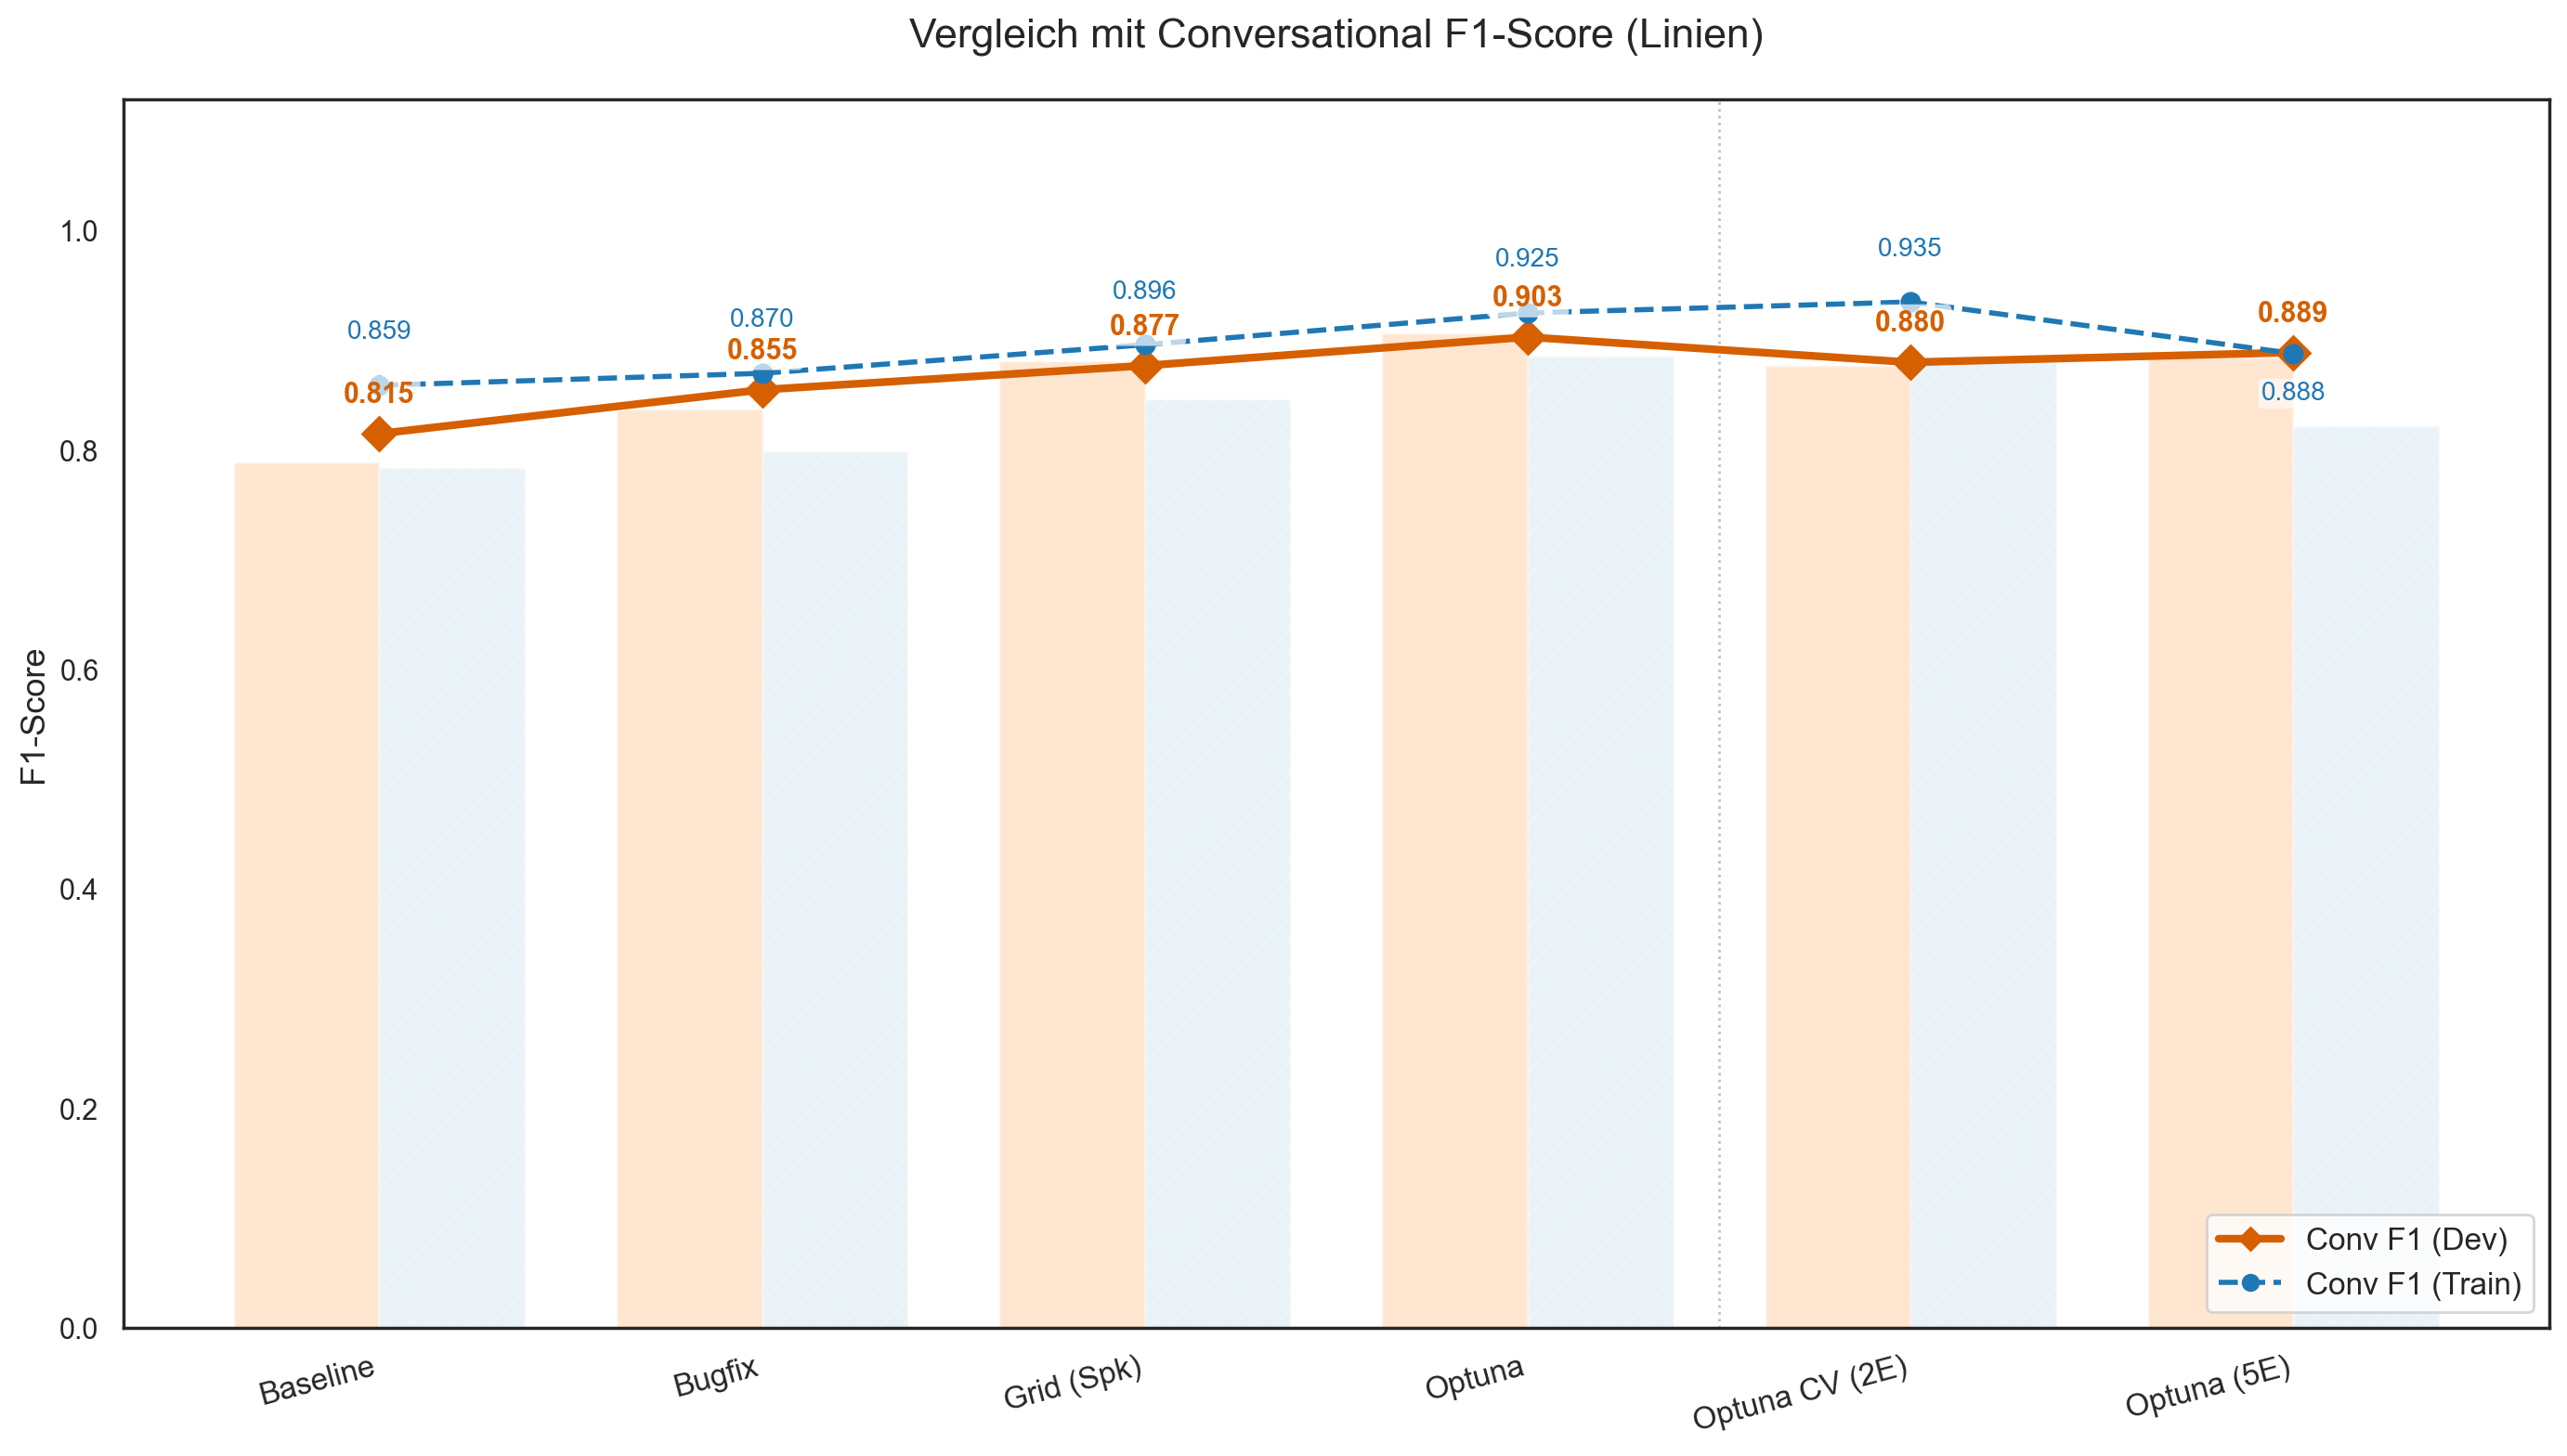

In [25]:
plot_lines_final()